# wombat demo

In this demo, we'll be using the CartPole-v0 environment from the OpenAI gym. Wombat supports OpenAI-gym-like environments out of the box.  
If you want to use other environments, they must have `step()`, `reset()` and `close()` functioning like in gym.

In [1]:
import gym
env = gym.make('CartPole-v0')

We will create a simple DQN-like model in PyTorch. Note that wombat does not require PyTorch - it is equally compatible with eg. TensorFlow.

In [2]:
import numpy as np
import torch

model = torch.nn.Sequential(
    torch.nn.Linear(env.observation_space.shape[0], 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, env.action_space.n))

def get_expected_reward(observation):
    return model(torch.tensor(observation, dtype=torch.float32)).data.numpy()

optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
def optimize(observation, action, target_reward):
    prediction = model(torch.tensor(observation, dtype=torch.float32))[action]
    loss = (prediction - target_reward) ** 2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item() # used by wombat for eg. prioritized experience replay

Let's create our agent. You can think of the agent as the entire organism, with the model being the mind. We need to tell wombat how to run our model and how to optimize it.

In [3]:
import wombat
agent = wombat.agents.DQN(get_expected_reward, optimize)

It's training time! Let's define the training rules (what gets done when during training) and go!

In [4]:
train_offline = wombat.train.offline(weighter=wombat.train.weighters.prioritized(temperature=8)) # a weighter is used for prioritized experience replay
training_episodes = wombat.run(agent, env, 256, per_step=wombat.train.online(), per_episode=train_offline)

100%|██████████| 256/256 [03:49<00:00,  1.11it/s]


We're done! Let's see how well our agent does.

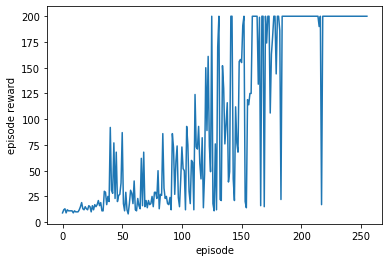

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot([episode.total_reward() for episode in training_episodes])
plt.xlabel('episode')
plt.ylabel('episode reward')
plt.show()

It works! Our model has learned to balance a pole on a cart, achieving a reward of 200 (maximum possible) in most of its final trials. Happy wombatting!